In [40]:
import pandas as pd
import xarray as xr

from lausanne_greening_scenarios.invest import utils as invest_utils

ModuleNotFoundError: No module named 'lausanne_greening_scenarios'

In [33]:
ref_et_filepath = '../data/interim/invest/ref-et.nc'
station_tair_filepath = '../data/interim/station-tair.csv'

In [28]:
station_tair_df = pd.read_csv(station_tair_filepath, index_col=0)
station_tair_df.index = pd.to_datetime(station_tair_df.index)
hottest_day = station_tair_df.index[station_tair_df.mean(axis=1).argmax()]

In [30]:
hottest_day

Timestamp('2019-07-24 00:00:00')

In [38]:
ref_et_da = xr.open_dataarray(ref_et_filepath).sel(time=hottest_day)

In [39]:
ref_et_da

<xarray.DataArray 'ref_eto' (y: 1052, x: 2131)>
[2241812 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2019-07-24
  * x        (x) float64 2.525e+06 2.525e+06 2.525e+06 ... 2.546e+06 2.546e+06
  * y        (y) float64 1.159e+06 1.159e+06 1.159e+06 ... 1.149e+06 1.149e+06
Attributes:
    units:         degree
    grid_mapping:  swiss_coordinates
    long_name:     daily minimum temperature
    grid_name:     ch01r.swisscors
    version:       v1.2
    prod_date:     2019-01-03 11:17:41
    pyproj_srs:    +proj=somerc +lat_0=46.9524055555556 +lon_0=7.439583333333...

In [1]:
import pandas as pd
from pylandsat import utils as pylandsat_utils

In [2]:
landsat_tiles_filepath = '../../lausanne-heat-islands/data/raw/landsat-tiles.csv'

In [3]:
landsat_dates = [
    pylandsat_utils.meta_from_pid(landsat_tile)['acquisition_date']
    for landsat_tile in pd.read_csv(landsat_tiles_filepath, header=None)[0]
]

In [7]:
pd.Series(landsat_dates).to_csv('../data/raw/calibration-dates.csv', index=False)

['2018-05-25',
 '2018-06-19',
 '2018-06-26',
 '2019-06-13',
 '2019-06-29',
 '2019-07-24',
 '2019-08-09',
 '2019-08-25']

In [65]:
scenario_lulc_da = xr.open_dataarray('../../_lausanne-heat-islands/data/processed/scenario-lulc.nc')

In [67]:
import numpy as np
import pandas as pd
import xarray as xr

shade_threshold = 0.75
HIGH_TREE_CLASS_VAL = 1
OTHER_CLASS_VAL = 2

scenario_lulc_filepath = '../../_lausanne-heat-islands/data/processed/scenario-lulc.nc'
biophysical_table_filepath = '../../_lausanne-heat-islands/data/processed/biophysical-table.csv'

scenario_lulc_da = xr.open_dataarray(scenario_lulc_filepath)

scenario_dims = scenario_lulc_da.coords.dims[:3]
res = scenario_lulc_da.attrs['transform'][0]
nodata = scenario_lulc_da.attrs['nodata']
change_props = scenario_lulc_da['change_prop'].values
scenario_runs = scenario_lulc_da['scenario_run'].values
num_scenario_runs = len(scenario_runs)

biophysical_df = pd.read_csv(biophysical_table_filepath)

row = dict(change_prop=0, interaction='cluster', scenario_run=0)
lulc_arr = scenario_lulc_da.sel(
    {scenario_dim: row[scenario_dim]
     for scenario_dim in scenario_dims}).values
landscape_arr = np.full_like(lulc_arr, nodata)
landscape_arr[lulc_arr != nodata] = OTHER_CLASS_VAL
landscape_arr[np.isin(
    lulc_arr, biophysical_df[biophysical_df['shade'] >= shade_threshold]
    ['lucode'])] = HIGH_TREE_CLASS_VAL

In [69]:
import matplotlib.pyplot as plt


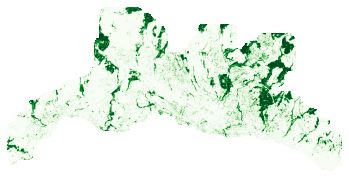

In [78]:
fig, ax = plt.subplots()
ax.imshow(np.where(landscape_arr != 0, landscape_arr, np.nan), cmap='Greens_r')
ax.set_axis_off()

In [ ]:
!conda install -y -c conda-forge pylandstats

In [79]:
import pylandstats as pls

ModuleNotFoundError: No module named 'pylandstats'

In [ ]:
pls.Landscape(landscape_arr, (res, res), nodata)

In [ ]:
import rasterio as rio
from rasterio import plot

In [9]:
from os import environ, path

import dotenv
import fsspec
import geopandas as gpd
import numpy as np
import pandas as pd
import pyeto
import salem  # noqa: F401
import xarray as xr
from rasterio import transform

from lausanne_greening_scenarios import utils

# 46.519833 degrees in radians
LAUSANNE_LAT = 0.811924

# constants useful for geo-operations
METEOSWISS_CRS = 'epsg:21781'
DROP_DIMS = ['lon', 'lat', 'dummy', 'swiss_coordinates']
RENAME_DIMS_MAP = {'chx': 'x', 'chy': 'y'}

# meteoswiss grid products needed to compute the reference evapotranspiration
METEOSWISS_GRID_PRODUCTS = ['TminD', 'TabsD', 'TmaxD']

# constants related to s3 remote file system
METEOSWISS_GRID_DATA_PREFIX = 'meteoswiss'
CACHE_STORAGE_DIR = path.join(path.dirname(utils.PACKAGE_ROOT),
                              'data/.meteoswiss-cache')


# meteoswiss utils
def preprocess_meteoswiss_ds(ds):
    # set crs attribute to dataset and all data variables individually
    ds.attrs['pyproj_srs'] = METEOSWISS_CRS
    for data_var in list(ds.data_vars):
        ds[data_var].attrs['pyproj_srs'] = METEOSWISS_CRS

    # drop unnecessary dimensions and rename the others so that salem can
    # understand the grid
    return ds.drop(DROP_DIMS).rename(RENAME_DIMS_MAP)


def open_meteoswiss_s3_ds(fs,
                          bucket_name,
                          year,
                          product,
                          open_kws=None,
                          shape=None,
                          geometry=None,
                          crs=None,
                          preprocess=False,
                          roi=True,
                          prefix=None,
                          subset_kws=None,
                          roi_kws=None):
    if prefix is None:
        prefix = METEOSWISS_GRID_DATA_PREFIX
    file_key = path.join(
        bucket_name, prefix, product,
        f'{product}_ch01r.swisscors_{year}01010000_{year}12310000.nc')
    with fs.open(file_key) as file_obj:
        if open_kws is None:
            open_kws = {}
        ds = xr.open_dataset(file_obj, **open_kws)

    if shape is not None or geometry is not None:
        ds = utils.clip_ds_to_extent(preprocess_meteoswiss_ds(ds),
                                     shape=shape,
                                     geometry=geometry,
                                     crs=crs,
                                     roi=roi,
                                     subset_kws=subset_kws,
                                     roi_kws=roi_kws)
    elif preprocess:
        ds = preprocess_meteoswiss_ds(ds)

    return ds


# other utils to compute the reference evapotranspiration
def compute_solar_radiation(date):
    lat = LAUSANNE_LAT
    day_of_year = date.timetuple().tm_yday
    sol_dec = pyeto.sol_dec(day_of_year)
    sha = pyeto.sunset_hour_angle(lat, sol_dec)
    ird = pyeto.inv_rel_dist_earth_sun(day_of_year)
    return pyeto.et_rad(lat, sol_dec, sha, ird)


def compute_ref_eto(day_ds):
    return pyeto.hargreaves(
        day_ds['TminD'], day_ds['TabsD'], day_ds['TmaxD'],
        compute_solar_radiation(pd.to_datetime(day_ds.time.values)))

In [3]:
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
dotenv.load_dotenv(dotenv.find_dotenv())

True

In [6]:
agglom_extent_filepath = '../data/raw/agglom-extent/agglom-extent.shp'
agglom_lulc_filepath = '../data/raw/agglom-lulc.tif'
year = 2019
buffer_dist = 200

In [44]:
import rasterio as rio
import salem

In [41]:
da = xr.open_dataarray('../../lausanne-heat-islands/data/processed/tair-ucm-maps.nc')

In [57]:
grid = da.salem.grid
width = grid.nx
height = grid.ny
west, east, south, north = grid.extent
with rio.open('tair.tif',
              'w',
              driver='GTiff',
              width=width,
              height=height,
              count=1,
              dtype=da.dtype,
              transform=transform.from_bounds(west, south, east, north, width,
                                              height),
              crs='epsg:2056') as dst:
    dst.write(da.isel(time=5).values, 1)

In [7]:
# get the agglomeration extent
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
crs = agglom_extent_gdf.crs
ref_geom = agglom_extent_gdf.loc[0]['geometry'].buffer(buffer_dist)
# lake_geom = agglom_extent_gdf.loc[1]['geometry']

# prepare remote access to MeteoSwiss grid data
fs = fsspec.filesystem(
    # 'filecache',
    'simplecache',
    target_protocol='s3',
    target_options=dict(
        profile=environ.get('S3_PROFILE_NAME'),
        client_kwargs={'endpoint_url': environ.get('S3_ENDPOINT_URL')}),
    cache_storage=CACHE_STORAGE_DIR)
bucket_name = environ.get('S3_BUCKET_NAME')

# pre-compute the meteo inputs
T_ds = xr.Dataset({
    meteoswiss_grid_product: open_meteoswiss_s3_ds(
        fs,
        bucket_name,
        year,
        meteoswiss_grid_product,
        geometry=ref_geom,
        crs=crs,
        roi_kws={'all_touched': True},
    )[meteoswiss_grid_product]
    for meteoswiss_grid_product in METEOSWISS_GRID_PRODUCTS
})

# select the hottest date
hottest_day_ds = T_ds.isel(time=T_ds['TabsD'].max(dim=['x', 'y']).argmax())

# reference evapotranspiration
ref_eto_da = compute_ref_eto(hottest_day_ds)

# align the reference evapotranspiration data-array to the agglom. LULC
ref_eto_da.name = 'ref_eto'
ref_eto_da.attrs = T_ds[list(T_ds.data_vars)[0]].attrs.copy()
ref_da = utils.salem_da_from_singleband(agglom_lulc_filepath, name='lulc')
ref_eto_da = ref_da.salem.transform(ref_eto_da, interp='linear')

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [10]:
ref_et_da = ref_eto_da.copy()

In [11]:
ref_et_da.name = 'ref_et'
grid = ref_et_da.salem.grid
width = grid.nx
height = grid.ny
west, east, south, north = grid.extent
# prepare metadata to dump the potential evapotranspiration rasters
meta = dict(driver='GTiff',
            dtype=ref_et_da.dtype,
            nodata=np.nan,
            width=width,
            height=height,
            count=1,
            transform=transform.from_bounds(west, south, east, north,
                                            width, height),
            crs=ref_et_da.attrs['pyproj_srs'])

In [16]:
from os import environ, path

import dotenv
import fsspec
import geopandas as gpd
import pandas as pd
import pyeto
import xarray as xr

from lausanne_greening_scenarios import utils

# 46.519833 degrees in radians
LAUSANNE_LAT = 0.811924

# constants useful for geo-operations
METEOSWISS_CRS = 'epsg:21781'
DROP_DIMS = ['lon', 'lat', 'dummy', 'swiss_coordinates']
RENAME_DIMS_MAP = {'chx': 'x', 'chy': 'y'}

# meteoswiss grid products needed to compute the reference evapotranspiration
METEOSWISS_GRID_PRODUCTS = ['TminD', 'TabsD', 'TmaxD']

# constants related to s3 remote file system
METEOSWISS_GRID_DATA_PREFIX = 'meteoswiss'
CACHE_STORAGE_DIR = path.join(path.dirname(utils.PACKAGE_ROOT),
                              'data/.meteoswiss-cache')


# meteoswiss utils
def preprocess_meteoswiss_ds(ds):
    # set crs attribute to dataset and all data variables individually
    ds.attrs['pyproj_srs'] = METEOSWISS_CRS
    for data_var in list(ds.data_vars):
        ds[data_var].attrs['pyproj_srs'] = METEOSWISS_CRS

    # drop unnecessary dimensions and rename the others so that salem can
    # understand the grid
    return ds.drop(DROP_DIMS).rename(RENAME_DIMS_MAP)


def open_meteoswiss_s3_ds(fs,
                          bucket_name,
                          year,
                          product,
                          open_kws=None,
                          shape=None,
                          geom=None,
                          crs=None,
                          preprocess=False,
                          roi=True,
                          prefix=None,
                          subset_kws=None,
                          roi_kws=None):
    if prefix is None:
        prefix = METEOSWISS_GRID_DATA_PREFIX
    file_key = path.join(
        bucket_name, prefix, product,
        f'{product}_ch01r.swisscors_{year}01010000_{year}12310000.nc')
    with fs.open(file_key) as file_obj:
        if open_kws is None:
            open_kws = {}
        ds = xr.open_dataset(file_obj, **open_kws)

    if shape is not None or geom is not None:
        ds = utils.clip_ds_to_extent(preprocess_meteoswiss_ds(ds),
                                     shape=shape,
                                     geom=geom,
                                     crs=crs,
                                     roi=roi,
                                     subset_kws=subset_kws,
                                     roi_kws=roi_kws)
    elif preprocess:
        ds = preprocess_meteoswiss_ds(ds)

    return ds


# other utils to compute the reference evapotranspiration
def compute_solar_radiation(date):
    lat = LAUSANNE_LAT
    day_of_year = date.timetuple().tm_yday
    sol_dec = pyeto.sol_dec(day_of_year)
    sha = pyeto.sunset_hour_angle(lat, sol_dec)
    ird = pyeto.inv_rel_dist_earth_sun(day_of_year)
    return pyeto.et_rad(lat, sol_dec, sha, ird)


def compute_ref_eto(day_ds):
    return pyeto.hargreaves(
        day_ds['TminD'], day_ds['TabsD'], day_ds['TmaxD'],
        compute_solar_radiation(pd.to_datetime(day_ds.time.values)))

In [15]:
# get the agglomeration extent
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
crs = agglom_extent_gdf.crs
ref_geom = agglom_extent_gdf.loc[0]['geometry'].buffer(buffer_dist)
# lake_geom = agglom_extent_gdf.loc[1]['geometry']

# prepare remote access to MeteoSwiss grid data
fs = fsspec.filesystem(
    # 'filecache',
    'simplecache',
    target_protocol='s3',
    target_options=dict(
        profile=environ.get('S3_PROFILE_NAME'),
        client_kwargs={'endpoint_url': environ.get('S3_ENDPOINT_URL')}),
    cache_storage=CACHE_STORAGE_DIR)
bucket_name = environ.get('S3_BUCKET_NAME')

# pre-compute the meteo inputs
T_ds = xr.Dataset({
    meteoswiss_grid_product: open_meteoswiss_s3_ds(
        fs,
        bucket_name,
        year,
        meteoswiss_grid_product,
        geom=ref_geom,
        crs=crs,
        roi_kws={'all_touched': True},
    )[meteoswiss_grid_product]
    for meteoswiss_grid_product in METEOSWISS_GRID_PRODUCTS
})

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


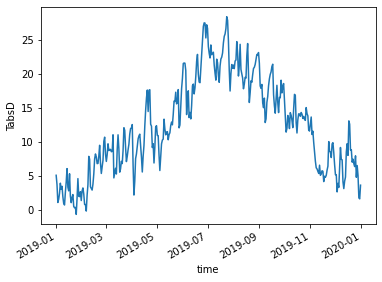

In [27]:
T_ds.max(dim=['x', 'y'])['TabsD'].plot()

In [62]:
pd.to_datetime(T_ds.isel(time=T_ds['TabsD'].max(dim=['x', 'y']).argmax()).time.item()).strftime('%d-%m-%Y')

'24-07-2019'

In [ ]:
compute_ref_eto(T_ds.isel(time=T_ds['TabsD'].max(dim=['x', 'y']).argmax()))

<xarray.DataArray (y: 11, x: 21)>
array([[5.2909594,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan, 4.865494 , 4.906884 ],
       [5.261122 , 5.2384963,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan, 4.7793427,
        4.7942624, 4.656985 , 4.7230625],
       [5.2110786, 5.2069936, 5.169689 , 5.1395636,       nan, 5.0610986,
        5.015864 , 4.976732 ,       nan,       nan,       nan, 4.8283916,
        4.7728343, 4.7404804, 4.711468 , 4.6922574, 4.6991606, 4.6796365,
        4.648395 , 4.9960756, 5.1365247],
       [5.1590157, 5.15659  , 5.1493773, 5.1188974, 5.079329 , 5.0284505,
        4.9824333, 4.937702 , 4.911682 , 4.8895264, 4.836131 , 4.7987876,
        4.7039657, 4.6146398, 4.5885253, 4.5752144, 4.59774  , 4.673849 ,
        4.865025 , 5.0652947, 5.203598 ],
       [5.098699 , 5.0738735, 5.0553813, 5.082386 , 5.0507145, 4.957926 ,
        4.9616694, 4.8800473, 4.8728814, 4.8677115, 4.7931104, 4.6673517,
        4.631064 , 4.674183 , 4.6997356, 4.7237825, 4.7637033, 4.9881186,
        5.051137 , 5.179712 , 5.1955347],
       [5.111902 , 5.0548553, 5.016854 , 4.947608 , 4.939967 , 4.95192  ,
        4.9455075, 4.8639493, 4.857195 , 4.7944136, 4.691984 , 4.677702 ,
        4.7805166, 4.828952 , 4.845099 , 4.9269958, 4.9407053, 5.1136904,
        5.224701 , 5.253966 ,       nan],
       [      nan,       nan, 5.0196333, 4.9221   , 4.905809 , 4.833631 ,
        4.889557 , 4.8803554, 4.8205934, 4.748811 , 4.708181 , 4.8214936,
        4.9015975, 4.953347 , 4.973045 , 5.0236564, 5.092672 , 5.144432 ,
        5.2071104,       nan,       nan],
       [      nan,       nan,       nan,       nan, 4.876099 , 4.8685   ,
        4.9157295, 4.853591 , 4.7890854, 4.728623 , 4.8069944, 4.932525 ,
        4.950519 , 5.03128  , 5.090124 , 5.1405015, 5.026463 , 5.0312757,
        5.0675073,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan, 4.912998 ,
        4.8386545, 4.7964454, 4.7641287, 4.8366117, 4.9040723, 4.994538 ,
        5.011764 , 5.11074  , 5.1957026, 5.1831803, 4.869819 , 4.8715672,
        4.868311 ,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan, 4.9122605,
        4.839577 , 4.8655486, 4.891329 , 4.9323974, 4.988305 , 5.009044 ,
        5.10724  , 5.1511865, 5.2080913, 5.031778 , 4.869008 , 4.86932  ,
        4.859481 ,       nan,       nan],
       [      nan,       nan,       nan,       nan,       nan, 4.9274793,
        4.8718147, 4.9555135, 5.0021   , 5.0119987, 5.035132 , 5.0342183,
        5.139148 , 5.1934853, 5.0862913,       nan,       nan,       nan,
              nan,       nan,       nan]], dtype=float32)
Coordinates:
  * x        (x) float64 5.255e+05 5.265e+05 5.275e+05 ... 5.445e+05 5.455e+05
  * y        (y) float64 1.485e+05 1.495e+05 1.505e+05 ... 1.575e+05 1.585e+05
    time     datetime64[ns] 2019-07-24

In [39]:
T_ds.isel(time=T_ds['TabsD'].max(dim=['x', 'y']).argmax()).map(compute_ref_eto)

KeyError: 'TminD'